In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%config Completer.use_jedi = False

In [2]:
from modules.evaluation import EvaluationFramework
# Ensemble Methods
from modules.ensemble import EnsembleModelParameters
from pyod.models.lscp import LSCP 
from pyod.models.feature_bagging import FeatureBagging
# Detectors
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM

/home/harrison/.virtualenvs/anomaly_detection/lib/python3.6/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [3]:
import numpy as np

def generate_data():
    x1 = np.random.multivariate_normal([10,24,1], [[5,0,0],[0,15,0],[0,0,1]], 100)
    x2 = np.random.multivariate_normal([10,24,1], [[15,0,0],[0,5,0],[0,0,2]], 100)
    x3 = np.random.multivariate_normal([10,24,1], [[5,0,0],[0,4,0],[0,0,13]], 100)
    x4 = np.array(list(zip(np.random.uniform(-50,50,10), np.random.uniform(-50,50,10), np.random.uniform(-50,50,10))))

    X = np.concatenate([x1, x2, x3, x4])
    Y = np.concatenate([np.zeros(len(x1)), np.zeros(len(x2)), np.zeros(len(x3)), np.ones(len(x4))])
    return (X,Y)

x,y = generate_data()

## EnsembleModelParameters

### Average of Estimators

In [16]:
# 5 iForest models with the same parameters
params_iforest = {
    'n_estimators':[100,50,10,2,80],
    'max_features':[1,2,3,1,1]
}

In [17]:
ens_iforest = EnsembleModelParameters(IForest, params_iforest)

In [18]:
eva_iforest = EvaluationFramework(ens_iforest)
eva_iforest.fit(x)

In [19]:
predictions = eva_iforest.predict(x)
scores = eva_iforest.score(y,predictions)

In [20]:
scores

{'ROC-AUC': 0.97,
 'Detection-Rate': 1.0,
 'False-Alarm': 0.06,
 'F1-Score': 0.5263157894736842,
 'Log-Likelihood': 2.005523767297213}

In [26]:
y_preds = np.zeros((x.shape[0],ens_iforest.num_models))
for i in range(ens_iforest.num_models):
    y_preds[:,i] = ens_iforest.models[i].predict_proba(x)[:,1]

## Using barycenters to combining results

In [30]:
import ot

In [72]:
bins = np.linspace(0,1,20)

In [85]:
hists = np.zeros((bins.shape[0]-1,ens_iforest.num_models))
for i in range(hists.shape[1]):
    hist,bins = np.histogram(y_preds[:,i],bins=bins,density=True)
    hists[:,i] = hist/sum(hist)

In [89]:
n_distributions = hists.shape[1]
A = hists
# loss matrix + normalization
n = hists.shape[0]  # nb bins
M = ot.utils.dist0(n)
M /= M.max()

In [90]:
weights = np.array([1/ens_iforest.num_models]*ens_iforest.num_models)
# l2bary
bary_l2 = A.dot(weights)

# wasserstein
reg = 1e-3
bary_wass = ot.bregman.barycenter(A, M, reg, weights)

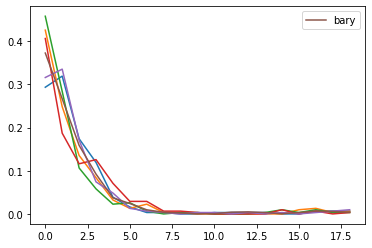

In [98]:
import matplotlib.pyplot as plt
for i in range(hists.shape[1]):
    plt.plot(hists[:,i])
plt.plot(bary_wass,label="bary")
plt.legend()

In [22]:
# Comparison with single
eva = EvaluationFramework(IForest(max_features=1))
eva.fit(x)
predictions = eva.predict(x)
eva.score(y,predictions)

{'ROC-AUC': 0.965,
 'Detection-Rate': 1.0,
 'False-Alarm': 0.07,
 'F1-Score': 0.4878048780487805,
 'Log-Likelihood': 2.339777728513415}

### Maximum of Estimators

In [77]:
params_pca = {
    'n_components': [i for i in range(1,x.shape[1]+1)]
}

In [79]:
ens = EnsembleModelParameters(PCA, params_pca)

In [80]:
eva = EvaluationFramework(ens)
eva.fit(x)

In [81]:
predictions = eva.predict(x)
scores = eva.score(y,predictions)

In [84]:
scores

{'ROC-AUC': 0.9666666666666667,
 'Detection-Rate': 1.0,
 'False-Alarm': 0.06666666666666667,
 'F1-Score': 0.5,
 'Log-Likelihood': 2.2283597414413476}

In [85]:
# Comparison with single
eva = EvaluationFramework(PCA())
eva.fit(x)
predictions = eva.predict(x)
eva.score(y,predictions)

{'ROC-AUC': 0.965,
 'Detection-Rate': 1.0,
 'False-Alarm': 0.07,
 'F1-Score': 0.4878048780487805,
 'Log-Likelihood': 2.339777728513415}

### LSCP: Locally Selective Combination of Parallel Outlier Ensembles

Subsets the data into 'local regions' and chooses one of the potential detectors for each region.

In [92]:
selected_detectors = [IForest(), KNN(), PCA(), OCSVM()]
model = LSCP(selected_detectors)

In [93]:
eva = EvaluationFramework(model)
eva.fit(x)

C:\Users\Michael\miniconda3\envs\anomaly\lib\site-packages\pyod\models\lscp.py:383: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


In [94]:
predictions = eva.predict(x)
scores = eva.score(y,predictions)
scores

{'ROC-AUC': 0.9733333333333333,
 'Detection-Rate': 1.0,
 'False-Alarm': 0.05333333333333334,
 'F1-Score': 0.5555555555555556,
 'Log-Likelihood': 1.7826877931530787}

### Feature Bagging

In [107]:
base_estimator=PCA()
model = FeatureBagging(base_estimator=base_estimator, n_estimators=10)

In [108]:
eva = EvaluationFramework(model)
eva.fit(x)

In [109]:
predictions = eva.predict(x)
scores = eva.score(y,predictions)
scores

{'ROC-AUC': 0.965,
 'Detection-Rate': 1.0,
 'False-Alarm': 0.07,
 'F1-Score': 0.4878048780487805,
 'Log-Likelihood': 2.339777728513415}